# The LogCA model

This notebook constructs the [LogCA model](https://dl.acm.org/doi/pdf/10.1145/3140659.3080216) to analytically model simple host-accelerator interaction

## LogCA parameters

| Parameter                  | Description                                       | Units |
|:---------------------------|:--------------------------------------------------|-------|
|$L$ - Latency             | Cycles to move data from the host to the accelerator across the interface, including the cycles data spends in the caches or memory | Cycles |
|$o$ - Overhead            | Cycles the host spends in setting up the algorithm | Cycles |
|$g$ - Granularity         | Size of the offloaded data | Bytes |
|$C$ - Computational Index | Cycles the host spends per byte of data | Cycles/Byte |
|$A$ - Acceleration        | The peak speedup of an accelerator | N/A |

### Other parameters:
- ```complexity_power_factor``` ($ \beta $) is the power factor of the complexity of the alogrithm as a function of granularity as per the model.
- ```is_latency_granularity_depend``` indicates whether the latency is dependant on granularity.

In [156]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass

@dataclass
class Parameters:
    latency: int
    overhead: int
    computational_index: float
    acceleration: int
    complexity_power_factor: float
    is_latency_granularity_depend: bool

Compute the speedup for given LogCA parameters. 

In [103]:
def speedup(p, granularity):
    p.host_comp_index = p.computational_index * (granularity ** p.complexity_power_factor)
    actual_latency = p.latency
    
    if(p.is_latency_granularity_depend):
        actual_latency = p.latency * granularity
            
    return p.host_comp_index / (actual_latency + p.overhead + (p.host_comp_index / p.acceleration))

Compute break-even granularity $ g_1 $. It is the granularity required to achieve a speedup of 1.

In [104]:
def break_even_granularity(p):
    
    if(p.is_latency_granularity_depend):
        return ((p.computational_index * (p.complexity_power_factor - 1) * (p.acceleration - 1) + p.acceleration * p.overhead) / \
               (p.computational_index * p.complexity_power_factor * (p.acceleration - 1) - p.acceleration * p.latency))
    
    return ((p.acceleration / (p.acceleration - 1)) * ((p.overhead + p.latency) / p.computational_index)) ** (1 / p.complexity_power_factor)

Compute half-speedup granularity $ g_{A/2} $.

In [105]:
def half_speedup_granularity(p):
    
    if(p.is_latency_granularity_depend):
        return ((p.computational_index * (p.complexity_power_factor - 1) + p.acceleration * p.overhead) / \
               (p.computational_index * p.complexity_power_factor - p.acceleration * p.latency))
    
    return (p.acceleration * ((p.overhead + p.latency) / p.computational_index)) ** (1 / p.complexity_power_factor)

def half_speedup_granularity_from_beg(be_granularity,
                             acceleration,
                             complexity_power_factor):
    
    return ((acceleration - 1) ** (1 / complexity_power_factor)) * be_granularity

### Example system

The below parameters model an APU with FFT and AES kernels as described in the paper.

In [106]:
latency_apu = 15
overhead_apu = 4 * 10**8
acceleration_apu = 7

# Speedup achieved with accelerator at break-even granularity must be 1
# Speedup achieved with accelerator at half-speedup granularity must be A/2 = 3.5

# FFT
computational_index_fft = 290
complexity_power_factor_fft = 1.2

params_apu_fft = Parameters(latency=latency_apu, 
                            overhead=overhead_apu, 
                            computational_index=290, 
                            acceleration=acceleration_apu, 
                            complexity_power_factor=1.2, 
                            is_latency_granularity_depend=False)

beg_apu_fft = break_even_granularity(params_apu_fft)
hsg_apu_fft = half_speedup_granularity(params_apu_fft)

print("FFT kernel on APU: ")
print("Break-even granularity: ", beg_apu_fft)
print("Speedup achieved with accelerator at break-even granularity: ", speedup(params_apu_fft, beg_apu_fft))
print("Half-speedup granularity: ", hsg_apu_fft)
print("Speedup achieved with accelerator at half-speedup granularity: ", speedup(params_apu_fft, hsg_apu_fft)) 

# AES
params_apu_aes = Parameters(latency=latency_apu, 
                            overhead=overhead_apu, 
                            computational_index=174, 
                            acceleration=acceleration_apu, 
                            complexity_power_factor=1, 
                            is_latency_granularity_depend=True)

beg_apu_aes = break_even_granularity(params_apu_aes)
hsg_apu_aes = half_speedup_granularity(params_apu_aes)

print("\nAES kernel on APU: ")
print("Break-even granularity: ", beg_apu_aes)
print("Speedup achieved with accelerator at break-even granularity: ", speedup(params_apu_aes, beg_apu_aes))
print("Half-speedup granularity: ", hsg_apu_aes)
print("Speedup achieved with accelerator at half-speedup granularity: ", speedup(params_apu_aes, hsg_apu_aes)) 

FFT kernel on APU: 
Break-even granularity:  148653.1099524985
Speedup achieved with accelerator at break-even granularity:  0.9999999999999999
Half-speedup granularity:  661657.7058444184
Speedup achieved with accelerator at half-speedup granularity:  3.5000000000000004

AES kernel on APU: 
Break-even granularity:  2981895.633652822
Speedup achieved with accelerator at break-even granularity:  1.0
Half-speedup granularity:  40579710.14492754
Speedup achieved with accelerator at half-speedup granularity:  3.5


## Gridding comparison experiment

A comparison experiment between the CPU + GPU system from SDP Memo 72 (and others) and a simple integrated SoC architecture with a DSA for the W-projection gridding kernel.

Need to compare between maximum speedups and break-even and half-speedup granularities

### Kernel parameters
Convert complexity in terms of number of elements $n$, $\mathcal{O}{(n^{x})}$ to in terms of granularity $g$, $\mathcal{O}{(g^{\beta})}$

- Complexity power factor ($\beta$) = 

### LogCA parameters


#### CPU + GPU model
- Latency = 
- Overhead =
- Computational index = 
- Acceleration =
- Is latency dependent on granularity? - 


#### SoC model
- Latency = 
- Overhead =
- Computational index = 
- Acceleration =
- Is latency dependent on granularity? - 


## Visualization

Generate granularity vs speedup plots for different experiments.

TODO:
- [ ] Check for validity of break-even and half-speed granularities (FFT example in paper)
- [ ] Add proper coloring for plots
- [ ] Decrease axis padding

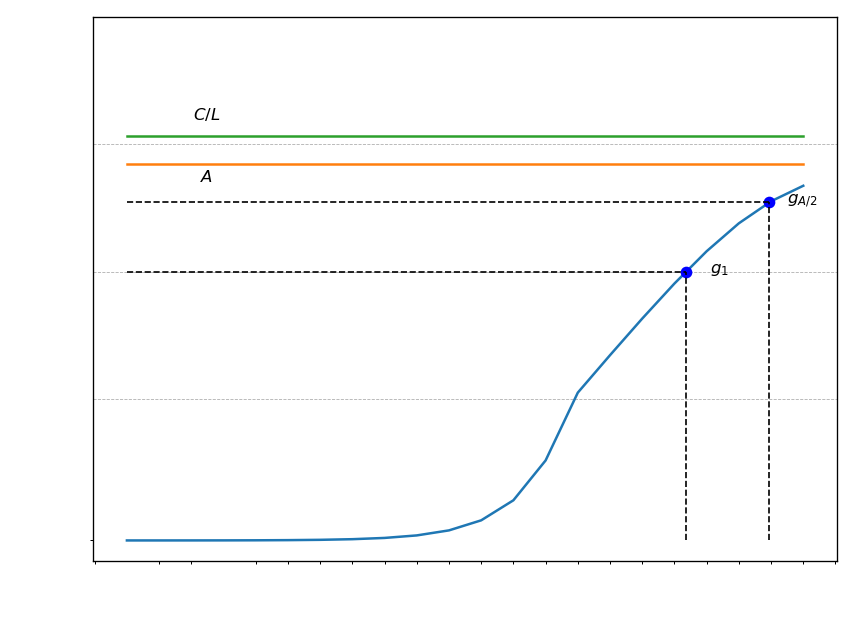

In [236]:
def plot_granularity_to_speedup(params):
    # To view in jupyter dark mode
    dark_mode = True
    
    # Model constants
    acc = params.acceleration
    c_by_l = params.computational_index/params.latency
    beg = break_even_granularity(params)
    hsg = half_speedup_granularity(params)

    # Granularity values and tick formatting
    grans = np.logspace(4, 25, 22, endpoint=True, base=2)
    x_format = {16:'16', 128:'128', 1000:'1K', 8000:'8K', 64000:'64K', 512000:'512K', 4000000:'4M', 32000000:'32M'}
    x_format_keys = list(x_format.keys()) 

    # Function to draw projections from single point to axis
    def draw_projections(plt, xmin, ymin, xmax, ymax):
        plt.plot([xmin, xmax], [ymax, ymax], color = 'black', linestyle = '--', linewidth = 1)
        plt.plot([xmax, xmax], [ymin, ymax], color = 'black', linestyle = '--', linewidth = 1)

    # Figure properties
    fig = plt.figure(figsize=(8,6), dpi=120)
    ax = fig.add_subplot(111)
    
    # Granularity - speedup plot
    plt.plot(grans, speedup(params, grans))

    # Acceleration line
    plt.plot([grans[0], grans[len(grans) - 1]], [acc, acc])
    plt.annotate('$A$', (128, acc), textcoords="offset points", xytext=(-10,-10), ha='center')

    # C/L line
    plt.plot([grans[0], grans[len(grans) - 1]], [c_by_l, c_by_l])
    plt.annotate('$C/L$', (128, c_by_l), textcoords="offset points", xytext=(-10,10), ha='center')

    # Break-even granularity
    plt.plot(beg, 1, 'bo')
    plt.annotate('$g_1$', (beg, 1), textcoords="offset points", xytext=(20,0), ha='center')
    draw_projections(plt, grans[0], 0, beg, 1)

    # Half-speedup granularity
    plt.plot(hsg, acc/2, 'bo')
    plt.annotate('$g_{A/2}$', (hsg, acc/2), textcoords="offset points", xytext=(20,0), ha='center')
    draw_projections(plt, grans[0], 0, hsg, acc/2)

    # Axis labels, scales and grid
    plt.xlabel('Granularities')
    plt.ylabel('Speedup')
    plt.xscale('symlog', base=2)
    plt.yscale('symlog', linthresh=0.1)
    plt.grid(axis='y', linestyle = '--', linewidth = 0.5)

    if(dark_mode):
        ax.xaxis.label.set_color('white')
        ax.yaxis.label.set_color('white')
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')

    # y-axis tick formatting
    ax.set_yticks([0.1, 1, 10, 100])
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

    # x-axis tick formatting
    ax.set_xticks(x_format_keys)
    def x_format_func(value, tick_number):
        return x_format[value]
    ax.xaxis.set_major_formatter(plt.FuncFormatter(x_format_func))

    plt.show()
    
params_apu_aes = Parameters(latency=latency_apu, 
                            overhead=overhead_apu, 
                            computational_index=174, 
                            acceleration=acceleration_apu, 
                            complexity_power_factor=1, 
                            is_latency_granularity_depend=False)
    
plot_granularity_to_speedup(params_apu_aes)

A simple experimental model to model the performance of W-projection gridding algorithm.

In [107]:
import time

I = 10
J = 10
K = 10
L = 2

(DISCRETE, INTEGRATED) = (True, False)

def __gridding_model__(in_latency, processing_delay, out_latency):
    # Adjust the latency and delay numbers according to SDP Memo
    # Please add more loops as necessary
    time.sleep(in_latency)
    m = 0
    for i in range(1,I):
        for j in range(1,J):
            for k in range(1,K):
                for l in range (1,L):
                    time.sleep(processing_delay)
                    m+=1
    time.sleep(out_latency)
    return m

def discrete_accelerated_gridding():
    # in_latency is high, 
    # processing delay is low (as CPUs are slower than accelerators), 
    # out_latency is high 

    return __gridding_model__(1.0, 0.001, 1.0)
    
def integrated_accelerated_gridding():
    # in_latency is low, 
    # processing delay is low (as CPUs are slower than accelerators), 
    # out_latency is low
    return __gridding_model__(0.001, 0.001, 0.001)

def accelerated_gridding(mode):
    if mode == DISCRETE:
        return discrete_accelerated_gridding()
    else:
        return integrated_accelerated_gridding()

def cpu_gridding():
    # in_latency is low, 
    # processing delay is high (as CPUs are slower than accelerators), 
    # out_latency is low
   return __gridding_model__(0.001, 0.01, 0.001) 


def main():
    start = time.perf_counter()
    cpu_gridding()
    print("cpu_gridding: ", time.perf_counter() - start)

    start = time.perf_counter()
    discrete_accelerated_gridding()
    print("discrete_accelerated_gridding: ", time.perf_counter() - start)

    start = time.perf_counter()
    integrated_accelerated_gridding()
    print("integrated_accelerated_gridding: ", time.perf_counter() - start)

main()



cpu_gridding:  7.421209377003834
discrete_accelerated_gridding:  2.8324038540013134
integrated_accelerated_gridding:  0.8357478969846852
